In [3]:
%matplotlib inline
import tweepy
import cnfg
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from pymongo import MongoClient
from tweepy import Stream
from tweepy.streaming import StreamListener
import json
import os
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns  
import numpy as np
import gensim
import pprint
pp = pprint.PrettyPrinter()

pd.set_option('display.max_colwidth', 200)

In [4]:
# Connect to monogodb server, start mongod in terminal to run
client = MongoClient('localhost', 27017)

In [5]:
client.list_database_names()

['admin', 'config', 'local', 'twitter_database']

In [6]:
twitter_db = client['twitter_database']
tweet_collection = twitter_db.rdr2_no_retweets_2

# First do all preprocessing

In [7]:
import re
pattern = re.compile('^(?!.*http.).*$', re.IGNORECASE)
# Limiting the tweets used to a certain number, because I kept on collecting and I didn't want my results to keep changing as I collected
twitter_text_test = tweet_collection.find({'text':{'$regex':pattern}}).limit(9264)
twitter_text_list = [item for item in twitter_text_test]
rdr2_tweets_df = pd.DataFrame(twitter_text_list)
rdr2_tweets_df.loc[:,'_id'] = rdr2_tweets_df._id.apply(lambda x: str(x))
rdr2_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9264 entries, 0 to 9263
Data columns (total 8 columns):
_id               9264 non-null object
created_at        9264 non-null object
favorite_count    9264 non-null int64
retweet_count     9264 non-null int64
screen_name       9264 non-null object
sentiment         9264 non-null float64
subjectivity      9264 non-null float64
text              9264 non-null object
dtypes: float64(2), int64(2), object(4)
memory usage: 579.1+ KB


0.016405688008956604

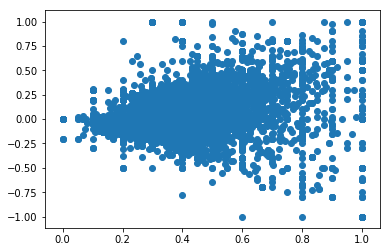

In [8]:
# simple plot of tweet sentiment
plt.scatter(list(rdr2_tweets_df.sort_values(by = 'subjectivity').subjectivity), list(rdr2_tweets_df.sort_values(by = 'subjectivity').sentiment));
overall_tweet_sentiment = np.mean(rdr2_tweets_df.sentiment)
overall_tweet_sentiment
# surprised that it is negative on average, given the attention and how good it seems to be received in general

In [9]:
rdr2_tweets_df.head()

,_id,created_at,favorite_count,retweet_count,screen_name,sentiment,subjectivity,text
0,5be8c1412af8b82a53bb9ed3,Sun Nov 11 23:54:36 +0000 2018,0,0,Mxster_Shimxda,0.1,0.466667,(Red Dead Redemption is just Grand Theft Yeehaw.
1,5be8c1722af8b82a53bb9edb,Sun Nov 11 23:55:25 +0000 2018,0,0,josepire31,-0.1,0.200000,Red dead redemption 2 para xbox one 👌🏼
2,5be8c17d2af8b82a53bb9edd,Sun Nov 11 23:55:36 +0000 2018,0,0,ditzidoggie,-0.1,0.200000,I got the red dead redemption 2 guide so im gonna nerd out and check out these neat locations
3,5be8c1832af8b82a53bb9edf,Sun Nov 11 23:55:41 +0000 2018,0,0,DViz,-0.1,0.200000,@psychotriaplays “Red Dead Redemption 0”
4,5be8c1bc2af8b82a53bb9ee4,Sun Nov 11 23:56:39 +0000 2018,0,0,Samantha12Sue,-0.1,0.200000,banana blunts &amp; Red Dead Redemption 2🍌🎮


In [10]:
# text = u'This dog \U0001f602'
# print(text)
pattern = re.compile("["
        u"\U0001F300-\U0001F6FF"  # symbols & pictographs
                           "]+", flags=re.UNICODE)
rdr2_tweets_df.loc[:, 'text_clean'] = rdr2_tweets_df.text.apply(lambda x: re.sub(pattern,'',x))
rdr2_tweets_df.loc[:, 'text_clean'] = rdr2_tweets_df.text_clean.apply(lambda x: re.sub('@','',x))
rdr2_tweets_df.loc[:, 'text_clean'] = rdr2_tweets_df.text_clean.apply(lambda x: x.lower())
# print(emoji_pattern.sub(r'', text)) # no emoji
# print(re.sub(emoji_pattern, '', text))

In [11]:
rdr2_tweets_df.sort_values(by = 'created_at', ascending = True).head()

,_id,created_at,favorite_count,retweet_count,screen_name,sentiment,subjectivity,text,text_clean
9,5be8c2e12af8b82a53bb9f30,Mon Nov 12 00:01:32 +0000 2018,0,0,MGORedRanger89,-0.233333,0.466667,Well...that's Red Dead Redemption 2 finished....kinda sad now 😂,well...that's red dead redemption 2 finished....kinda sad now
10,5be8c2f02af8b82a53bb9f32,Mon Nov 12 00:01:47 +0000 2018,0,0,Devon_DaVinci,-0.100000,0.200000,Continuing my stream of Red Dead Redemption 2. Come check it out on Twitch &amp; YouTube.,continuing my stream of red dead redemption 2. come check it out on twitch &amp; youtube.
11,5be8c2f12af8b82a53bb9f33,Mon Nov 12 00:01:48 +0000 2018,0,0,jhop3e,0.200000,0.266667,"red dead redemption 2 au where i fight rockstar to the death, win, and then smooch arthur morgan","red dead redemption 2 au where i fight rockstar to the death, win, and then smooch arthur morgan"
12,5be8c3052af8b82a53bb9f35,Mon Nov 12 00:02:08 +0000 2018,0,0,ihatederek_k,-0.400000,0.450000,Red Dead Redemption 2 is the worst game ever programmed ever in the year 2018. @ me cowards.,red dead redemption 2 is the worst game ever programmed ever in the year 2018. me cowards.
13,5be8c3282af8b82a53bb9f3c,Mon Nov 12 00:02:42 +0000 2018,0,0,NubianBby,-0.133333,0.166667,Streaming Red Dead Redemption in a few 🐎,streaming red dead redemption in a few


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from nltk.corpus import stopwords
stop_words_list = list(stopwords.words('english'))
stop_words_list = stop_words_list + ['rdr2', 'rdr', 'red', 'dead', 'redemption', 'rt', 'game']

In [13]:
import string
rdr2_tweets_df.loc[:, 'text_no_stop'] = rdr2_tweets_df.text_clean
for punc in tqdm(string.punctuation):
    rdr2_tweets_df.loc[:, 'text_no_stop'] = rdr2_tweets_df.text_no_stop.apply(lambda x: x.replace(punc, ' '))
for word in tqdm(stop_words_list):
    rdr2_tweets_df.loc[:, 'text_no_stop'] = rdr2_tweets_df.text_no_stop.apply(lambda x: re.sub('(^|\s)'+word+'($|\s|\n)',' ',x))

100%|██████████| 186/186 [00:12<00:00, 14.83it/s]


In [14]:
rdr2_tweets_df.sort_values(by = 'created_at', ascending = True).head(5)

,_id,created_at,favorite_count,retweet_count,screen_name,sentiment,subjectivity,text,text_clean,text_no_stop
9,5be8c2e12af8b82a53bb9f30,Mon Nov 12 00:01:32 +0000 2018,0,0,MGORedRanger89,-0.233333,0.466667,Well...that's Red Dead Redemption 2 finished....kinda sad now 😂,well...that's red dead redemption 2 finished....kinda sad now,well 2 finished kinda sad
10,5be8c2f02af8b82a53bb9f32,Mon Nov 12 00:01:47 +0000 2018,0,0,Devon_DaVinci,-0.100000,0.200000,Continuing my stream of Red Dead Redemption 2. Come check it out on Twitch &amp; YouTube.,continuing my stream of red dead redemption 2. come check it out on twitch &amp; youtube.,continuing stream 2 come check twitch amp youtube
11,5be8c2f12af8b82a53bb9f33,Mon Nov 12 00:01:48 +0000 2018,0,0,jhop3e,0.200000,0.266667,"red dead redemption 2 au where i fight rockstar to the death, win, and then smooch arthur morgan","red dead redemption 2 au where i fight rockstar to the death, win, and then smooch arthur morgan",2 au fight rockstar death win smooch arthur morgan
12,5be8c3052af8b82a53bb9f35,Mon Nov 12 00:02:08 +0000 2018,0,0,ihatederek_k,-0.400000,0.450000,Red Dead Redemption 2 is the worst game ever programmed ever in the year 2018. @ me cowards.,red dead redemption 2 is the worst game ever programmed ever in the year 2018. me cowards.,2 worst ever programmed ever year 2018 cowards
13,5be8c3282af8b82a53bb9f3c,Mon Nov 12 00:02:42 +0000 2018,0,0,NubianBby,-0.133333,0.166667,Streaming Red Dead Redemption in a few 🐎,streaming red dead redemption in a few,streaming


In [15]:
corpus = list(rdr2_tweets_df.text_no_stop)
corpus = [tweet.split(' ') for tweet in corpus]

In [16]:
def filter(word):
    return ''.join(e for e in word if e.isalnum())

In [17]:
for i, tweet in enumerate(corpus):
    new_list = [filter(word) for word in tweet]
    corpus[i] = new_list

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(corpus, min_count=20)
trigram = gensim.models.Phrases(bigram[corpus], min_count=10)  

bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)
corpus = [trigram_model[bigram_model[t]] for t in corpus]

In [19]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# NOUN, ADJ, VERB, ADV
def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = []
    for sent in tqdm(texts):
        doc = nlp(' '.join(sent)) 
        output_text = [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.is_stop == False]
#         if len(output_text) > 0:
        texts_out.append(output_text)
    return texts_out

In [20]:
# takes ~44 secs
lemm_corpus = lemmatization(corpus)

100%|██████████| 9264/9264 [00:44<00:00, 210.34it/s]


In [21]:
from copy import deepcopy, copy
lemm_corpus_s = deepcopy(lemm_corpus)

In [22]:
for i, tweet in enumerate(lemm_corpus):
    lemm_corpus[i] = ' '.join(tweet)
    lemm_corpus[i].replace('-PRON-','')
    lemm_corpus[i].replace('pron','')
    if i < 5:
        print(lemm_corpus[i])

yeehaw
xbox_one
nerd location

banana blunt


In [23]:
vectorizer = CountVectorizer(min_df=1, ngram_range = (1,1), stop_words=stop_words_list, token_pattern='\\b[a-z][a-z]+\\b')
dtm = vectorizer.fit_transform(lemm_corpus)
dtm
# dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names())
dtm_df = pd.DataFrame(dtm.toarray(), index=rdr2_tweets_df._id, columns=vectorizer.get_feature_names())
dtm_df.head()

,aaa,aaaaa,aaaand,aajedi,aakh,aaron,aball,abduction,abdulllalsaleh,abeerandagame,...,zmanbrianzane,zoenlanosca,zombie,zone,zordon,zotaki,zscrollock,zteevin,zumbiezuza,zzrayannzz
_id,,,,,,,,,,,,,,,,,,,,,
5be8c1412af8b82a53bb9ed3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5be8c1722af8b82a53bb9edb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5be8c17d2af8b82a53bb9edd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5be8c1832af8b82a53bb9edf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5be8c1bc2af8b82a53bb9ee4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# LDA

In [24]:
id2word = gensim.corpora.Dictionary(lemm_corpus_s)
id2word.filter_extremes(no_below=2, no_above=0.5, keep_n=100000, keep_tokens=None)
corpus_lemm = [id2word.doc2bow(t) for t in lemm_corpus_s]

In [ ]:
# lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus_lemm,
#                                            id2word=id2word,
#                                            num_topics=5,
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=128,
#                                            per_word_topics=True)

In [25]:
# from sklearn.externals import joblib
# joblib.dump(lda_model, 'lda_model_noun.joblib')

from sklearn.externals import joblib
lda_model = joblib.load('lda_model_noun.joblib')

In [26]:
pp.pprint(lda_model.print_topics())

[(0,
  '0.099*"thegameaward" + 0.036*"people" + 0.029*"day" + 0.026*"guy" + '
  '0.021*"time" + 0.021*"shit" + 0.020*"life" + 0.017*"xbox" + 0.016*"game" + '
  '0.012*"mission"'),
 (1,
  '0.044*"game" + 0.044*"way" + 0.020*"hand" + 0.017*"gta" + 0.016*"money" + '
  '0.014*"fun" + 0.012*"thing" + 0.010*"fallout_76" + 0.010*"lot" + '
  '0.010*"level"'),
 (2,
  '0.050*"time" + 0.046*"rockstargame" + 0.037*"hour" + 0.026*"man" + '
  '0.019*"cowboy" + 0.017*"story" + 0.017*"tonight" + 0.016*"end" + '
  '0.016*"stream" + 0.015*"lol"'),
 (3,
  '0.061*"play" + 0.049*"horse" + 0.045*"spider_man" + 0.032*"gow" + '
  '0.027*"love" + 0.023*"week" + 0.021*"award" + 0.016*"video" + 0.016*"amp" + '
  '0.014*"lmao"'),
 (4,
  '0.089*"year" + 0.039*"celeste" + 0.037*"goty" + 0.036*"story" + '
  '0.034*"game" + 0.031*"win" + 0.028*"spider_man" + 0.025*"spiderman" + '
  '0.019*"vote" + 0.016*"list"')]


In [27]:
topic_list = []
topic_intensity = []

for i in tqdm(range(0,len(corpus_lemm))):
    top_topics = lda_model.get_document_topics(corpus_lemm[i])
    top_topics.sort(key=lambda x: x[1], reverse=True)
#     print(rdr2_tweets_df.iloc[i,0])
#     print(rdr2_tweets_df.iloc[i,7])
#     print(top_topics)
#     print(top_topics[0][0])
    topic_list.append(top_topics[0][0])
    topic_intensity.append(top_topics[0][1])
rdr2_tweets_df['topic'] = topic_list
rdr2_tweets_df['topic_intensity'] = topic_intensity

100%|██████████| 9264/9264 [00:02<00:00, 3179.39it/s]


In [29]:
# should probably use vader sentiment the Textblob model is really neutral
rdr2_tweets_df.groupby(by = 'topic').mean()

,favorite_count,retweet_count,sentiment,subjectivity,topic_intensity
topic,,,,,
0,0,0,-0.008716,0.304853,0.375651
1,0,0,0.013425,0.327155,0.548577
2,0,0,0.006791,0.331555,0.564786
3,0,0,0.019225,0.341062,0.557116
4,0,0,0.064635,0.371645,0.571965


In [32]:
# manually printing out top tweets of separate topics to get a feel for the topics
for i in range(0,20):
    print(rdr2_tweets_df.loc[rdr2_tweets_df.topic == 2].sort_values(by = 'topic_intensity', ascending = False).iloc[i,7])
    print()

Hey everyone!  I will be having new hours starting tomorrow (trying out many new things), I will be going live tomorrow at 8:30pm est. And streaming till 4am! That is right I am now gonna do 8 hour streams.  I will be doing more red dead redemption as well.  See ya tomorrow :)

Yet red dead redemption 2 and the last of us dont look mature to you right. Yes a super hero movie and a star wars is more mature. Time to block this troll

Solid 7+ hour stream today. I truly love Red Dead Redemption 2. Also almost at 200 followers and 1500 channel views on Mixer!

@EmperorBigD I'm playing Yakuza Kiwami, Dragon Quest XI and Red dead Redemption 2 all at the same time...okay like a few hours for each every sitting lol

My impression of Red Dead Redemption 2: Hold down L3 and R2 and tap X in a 9/8 time signature to brush the dust off your hat. #RedDeadRedemption2

Finally caught a clan meeting in the woods in red dead redemption 2. Fire bottles and tomahawks

Back home, caught up on some work, bee

In [384]:
# rdr2_tweets_df.to_pickle('topic_modeling_df.pkl')

In [380]:
# created a visualization that wasn't presented
# import pyLDAvis
# from pyLDAvis import gensim as gensimvis
# pyLDAvis.enable_notebook()
# vis = gensimvis.prepare(lda_model, corpus_lemm, id2word)
# pyLDAvis.save_html(vis, 'lda_noun.html')

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Sub topic modeling with LDA

In [33]:
rdr2_tweets_sub_df = rdr2_tweets_df.loc[(rdr2_tweets_df['topic'] == 1) | (rdr2_tweets_df['topic'] == 2) | (rdr2_tweets_df['topic'] == 3)].drop(columns = ['topic', 'topic_intensity'])

In [34]:
rdr2_tweets_sub_df.head()

,_id,created_at,favorite_count,retweet_count,screen_name,sentiment,subjectivity,text,text_clean,text_no_stop
1,5be8c1722af8b82a53bb9edb,Sun Nov 11 23:55:25 +0000 2018,0,0,josepire31,-0.100000,0.200000,Red dead redemption 2 para xbox one 👌🏼,red dead redemption 2 para xbox one,2 para xbox one
5,5be8c1e02af8b82a53bb9eed,Sun Nov 11 23:57:14 +0000 2018,0,0,BrettVilla,-0.050000,0.141667,Joel from The Last of Us is actually Arthur’s father from Red Dead Redemption 2. 🤔,joel from the last of us is actually arthur’s father from red dead redemption 2. 🤔,joel last us actually arthur’s father 2 🤔
6,5be8c1ff2af8b82a53bb9ef2,Sun Nov 11 23:57:46 +0000 2018,0,0,fearlessjew,-0.100000,0.200000,"The song that plays over the end credits for Red Dead Redemption 2 is ""Desperado"" by Rihanna six times in a row.","the song that plays over the end credits for red dead redemption 2 is ""desperado"" by rihanna six times in a row.",song plays end credits 2 desperado rihanna six times row
10,5be8c2f02af8b82a53bb9f32,Mon Nov 12 00:01:47 +0000 2018,0,0,Devon_DaVinci,-0.100000,0.200000,Continuing my stream of Red Dead Redemption 2. Come check it out on Twitch &amp; YouTube.,continuing my stream of red dead redemption 2. come check it out on twitch &amp; youtube.,continuing stream 2 come check twitch amp youtube
13,5be8c3282af8b82a53bb9f3c,Mon Nov 12 00:02:42 +0000 2018,0,0,NubianBby,-0.133333,0.166667,Streaming Red Dead Redemption in a few 🐎,streaming red dead redemption in a few,streaming


In [35]:
corpus_sub = list(rdr2_tweets_df.loc[(rdr2_tweets_df['topic'] == 1) | (rdr2_tweets_df['topic'] == 2) | (rdr2_tweets_df['topic'] == 3)].text_no_stop)
corpus_sub = [tweet.split(' ') for tweet in corpus_sub]

In [36]:
def filter(word):
    return ''.join(e for e in word if e.isalnum())

In [37]:
for i, tweet in enumerate(corpus_sub):
    new_list = [filter(word) for word in tweet]
    corpus_sub[i] = new_list

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(corpus_sub, min_count=20)

trigram = gensim.models.Phrases(bigram[corpus_sub], min_count=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)
corpus_sub = [trigram_model[bigram_model[t]] for t in corpus_sub]

In [39]:
nlp = spacy.load('en', disable=['parser', 'ner'])

# NOUN, ADJ, VERB, ADV
def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = []
    for sent in tqdm(texts):
        doc = nlp(' '.join(sent)) 
        output_text = [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.is_stop == False]
#         if len(output_text) > 0:
        texts_out.append(output_text)
    return texts_out

In [40]:
# about ~22s
lemm_corpus_sub = lemmatization(corpus_sub)

100%|██████████| 4441/4441 [00:22<00:00, 196.94it/s]


In [41]:
from copy import deepcopy, copy
lemm_corpus_sub_s = deepcopy(lemm_corpus_sub)

In [43]:
id2word = gensim.corpora.Dictionary(lemm_corpus_sub_s)
id2word.filter_extremes(no_below=2, no_above=0.5, keep_n=100000, keep_tokens=None)
corpus_lemm_sub = [id2word.doc2bow(t) for t in lemm_corpus_sub_s]

In [ ]:
# lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus_lemm_sub,
#                                            id2word=id2word,
#                                            num_topics=5,
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=128,
#                                            per_word_topics=True)

In [44]:
# from sklearn.externals import joblib
# joblib.dump(lda_model, 'lda_model_noun_sub.joblib')

from sklearn.externals import joblib
lda_model = joblib.load('lda_model_noun_sub.joblib')

In [45]:
pp.pprint(lda_model.print_topics())

[(0,
  '0.052*"game" + 0.046*"way" + 0.037*"man" + 0.028*"gow" + 0.025*"year" + '
  '0.023*"thegameaward" + 0.020*"hand" + 0.020*"end" + 0.018*"lmao" + '
  '0.018*"work"'),
 (1,
  '0.096*"play" + 0.045*"story" + 0.024*"game" + 0.021*"shit" + 0.018*"money" '
  '+ 0.018*"ps4" + 0.017*"arthur" + 0.013*"gta" + 0.013*"fallout" + '
  '0.012*"rockstargame"'),
 (2,
  '0.058*"spider_man" + 0.041*"love" + 0.039*"rockstargame" + 0.016*"cowboy" + '
  '0.015*"thank" + 0.015*"hell" + 0.014*"finish" + 0.011*"buy" + 0.011*"ass" + '
  '0.010*"day"'),
 (3,
  '0.089*"horse" + 0.035*"video" + 0.023*"lol" + 0.021*"award" + '
  '0.019*"mission" + 0.019*"chapter" + 0.014*"pc" + 0.014*"goty" + '
  '0.014*"youtube" + 0.013*"thing"'),
 (4,
  '0.083*"time" + 0.054*"hour" + 0.033*"week" + 0.025*"tonight" + '
  '0.025*"stream" + 0.024*"thing" + 0.024*"today" + 0.019*"tomorrow" + '
  '0.012*"cowboy" + 0.012*"night"')]


In [46]:
topic_list = []
topic_intensity = []

for i in tqdm(range(0,len(corpus_lemm_sub))):
    top_topics = lda_model.get_document_topics(corpus_lemm_sub[i])
    top_topics.sort(key=lambda x: x[1], reverse=True)
    topic_list.append(top_topics[0][0])
    topic_intensity.append(top_topics[0][1])
rdr2_tweets_sub_df['topic'] = topic_list
rdr2_tweets_sub_df['topic_intensity'] = topic_intensity

100%|██████████| 4441/4441 [00:01<00:00, 3084.36it/s]


In [47]:
# sentiment analysis still not working well with Textblob, should use vadersentiment trained on tweets
rdr2_tweets_sub_df.groupby(by = 'topic').mean()

,favorite_count,retweet_count,sentiment,subjectivity,topic_intensity
topic,,,,,
0,0,0,0.045673,0.351455,0.557997
1,0,0,-0.010745,0.334825,0.573491
2,0,0,0.023006,0.328680,0.579552
3,0,0,0.003570,0.325745,0.566566
4,0,0,-0.000285,0.325878,0.565469


In [49]:
# try vader sentiment, keep emojis in
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
rdr2_tweets_sub_df['text_vader'] = rdr2_tweets_sub_df.text.apply(lambda x: re.sub('redemption','',x, flags=re.IGNORECASE))
rdr2_tweets_sub_df['text_vader'] = rdr2_tweets_sub_df.text_vader.apply(lambda x: re.sub('dead','',x, flags=re.IGNORECASE))
rdr2_tweets_sub_df['text_vader'] = rdr2_tweets_sub_df.text_vader.apply(lambda x: re.sub('red','',x, flags=re.IGNORECASE))
rdr2_tweets_sub_df['vader_sentiment'] = rdr2_tweets_sub_df.text_vader.apply(lambda tweet: analyzer.polarity_scores(tweet)['compound']) 
rdr2_tweets_sub_df.head(2)

,_id,created_at,favorite_count,retweet_count,screen_name,sentiment,subjectivity,text,text_clean,text_no_stop,topic,topic_intensity,text_vader,vader_sentiment
1,5be8c1722af8b82a53bb9edb,Sun Nov 11 23:55:25 +0000 2018,0,0,josepire31,-0.10,0.200000,Red dead redemption 2 para xbox one 👌🏼,red dead redemption 2 para xbox one,2 para xbox one,1,0.599997,2 para xbox one 👌🏼,0.7297
5,5be8c1e02af8b82a53bb9eed,Sun Nov 11 23:57:14 +0000 2018,0,0,BrettVilla,-0.05,0.141667,Joel from The Last of Us is actually Arthur’s father from Red Dead Redemption 2. 🤔,joel from the last of us is actually arthur’s father from red dead redemption 2. 🤔,joel last us actually arthur’s father 2 🤔,4,0.599984,Joel from The Last of Us is actually Arthur’s father from 2. 🤔,0.0000


In [50]:
# better sentiment
rdr2_tweets_sub_df.groupby(by = 'topic').mean()

,favorite_count,retweet_count,sentiment,subjectivity,topic_intensity,vader_sentiment
topic,,,,,,
0,0,0,0.045673,0.351455,0.557997,0.180345
1,0,0,-0.010745,0.334825,0.573491,0.166792
2,0,0,0.023006,0.328680,0.579552,0.137926
3,0,0,0.003570,0.325745,0.566566,0.099875
4,0,0,-0.000285,0.325878,0.565469,0.165188


In [51]:
# high standard deviation
rdr2_tweets_sub_df.groupby(by = 'topic').std()

,favorite_count,retweet_count,sentiment,subjectivity,topic_intensity,vader_sentiment
topic,,,,,,
0,0.0,0.0,0.233417,0.217500,0.148110,0.467892
1,0.0,0.0,0.208861,0.203419,0.143962,0.453261
2,0.0,0.0,0.219774,0.212519,0.132702,0.463462
3,0.0,0.0,0.217563,0.200776,0.136026,0.449275
4,0.0,0.0,0.187275,0.196887,0.145695,0.454923


In [53]:
# count tweets in each topic
rdr2_tweets_sub_df.groupby(by = 'topic').count()._id

topic
0    944
1    844
2    940
3    832
4    881
Name: _id, dtype: int64

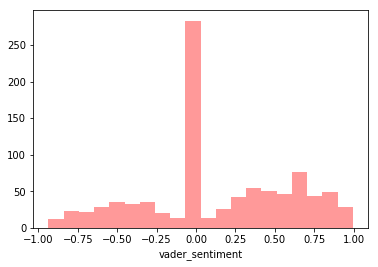

In [54]:
# topic 2 sentiment histogram
sns.distplot(rdr2_tweets_sub_df.vader_sentiment.loc[rdr2_tweets_sub_df.topic == 2],bins=20, kde = False, color = 'r');

In [55]:
overall_tweet_sentiment = np.mean(rdr2_tweets_sub_df.vader_sentiment)
overall_tweet_sentiment
# surprised that it is negative on average, given the attention and how good it seems to be received in general

0.1507082413870748

In [407]:
# rdr2_tweets_sub_df.to_pickle('topic_modeling_sub_df.pkl')

In [56]:
# printing out top tweets of a topic for the presentation
rdr2_tweets_sub_df.loc[rdr2_tweets_sub_df.topic == 2].sort_values(by = 'topic_intensity', ascending = False).iloc[0:5]

,_id,created_at,favorite_count,retweet_count,screen_name,sentiment,subjectivity,text,text_clean,text_no_stop,topic,topic_intensity,text_vader,vader_sentiment
347,5be8e7862af8b82a53bba471,Mon Nov 12 02:37:53 +0000 2018,0,0,benbonessi,-0.433333,0.570833,"red dead redemption 2 is trash. it’s a boring overblown intro to rpg/adventure for jabronis. quoting griffin here, but basically it’s like they turned the boring ass intro wagon scene from skyrim ...","red dead redemption 2 is trash. it’s a boring overblown intro to rpg/adventure for jabronis. quoting griffin here, but basically it’s like they turned the boring ass intro wagon scene from skyrim ...",2 trash it’s boring overblown intro rpg adventure jabronis quoting griffin basically it’s like turned boring ass intro wagon scene skyrim entire,2,0.911108,"2 is trash. it’s a boring overblown intro to rpg/adventure for jabronis. quoting griffin here, but basically it’s like they turned the boring ass intro wagon scene from skyrim into an entire game",-0.7269
692,5be90b922af8b82a53bba940,Mon Nov 12 05:11:41 +0000 2018,0,0,Jessins_,-0.181944,0.440278,@RockstarSupport I having a problem in Red Dead Redemption 2 where my honor bar will not increase despite me receiving dozens and dozens of good honor icons and reloading saved game if I receive b...,rockstarsupport i having a problem in red dead redemption 2 where my honor bar will not increase despite me receiving dozens and dozens of good honor icons and reloading saved game if i receive ba...,rockstarsupport problem 2 honor bar increase despite receiving dozens dozens good honor icons reloading saved receive bad ones still goes bad karma stopped going sudden,2,0.899790,@RockstarSupport I having a problem in 2 where my honor bar will not increase despite me receiving dozens and dozens of good honor icons and reloading saved game if I receive bad ones. It still...,-0.2803
6220,5beb6dfb2af8b83c06ea0042,Wed Nov 14 00:36:05 +0000 2018,0,0,scr33chh,-0.031250,0.300000,my real brother never let me play the og red dead redemption back in 2010. well jokes on him bc my frat brothers in wisconsin let me play red dead redemption 2 this weekend which real brother does...,my real brother never let me play the og red dead redemption back in 2010. well jokes on him bc my frat brothers in wisconsin let me play red dead redemption 2 this weekend which real brother does...,real brother never let play og back 2010 well jokes bc frat brothers wisconsin let play 2 weekend real brother doesn’t yet bc he’s lazy get job,2,0.899566,my real brother never let me play the og back in 2010. well jokes on him bc my frat brothers in wisconsin let me play 2 this weekend which real brother doesn’t have yet bc he’s too lazy to g...,-0.3553
6716,5beb773b2af8b83c06ea0448,Wed Nov 14 01:15:34 +0000 2018,0,0,_tRistanMCG,0.000000,0.000000,@geoffkeighley @insomniacgames @celeste_game @monsterhunter @RockstarGames @SonySantaMonica @assassinscreed I'd Vote #RDR2 for each category its nominated.,geoffkeighley insomniacgames celeste_game monsterhunter rockstargames sonysantamonica assassinscreed i'd vote #rdr2 for each category its nominated.,geoffkeighley insomniacgames celeste monsterhunter rockstargames sonysantamonica assassinscreed vote category nominated,2,0.885713,@geoffkeighley @insomniacgames @celeste_game @monsterhunter @RockstarGames @SonySantaMonica @assassinscreed I'd Vote #RDR2 for each category its nominated.,0.0000
4602,5beb51012af8b83c06e9f2b5,Tue Nov 13 22:32:28 +0000 2018,0,0,LeeroyBrown1978,0.000000,0.000000,"@RealThunder402 Fuckin @Treyarch are a joke, I’m deleting bo4 from my PlayStation to make room for RDR2 which I will be getting on payday. Call of duty is dying","realthunder402 fuckin treyarch are a joke, i’m deleting bo4 from my playstation to make room for rdr2 which i will be getting on payday. call of duty is dying",realthunder402 fuckin treyarch joke i’m deleting bo4 playstation make room getting payday call duty dying,2,0.885712,"@RealThunder402 Fuck

In [415]:
# visualization for 
# import pyLDAvis
# from pyLDAvis import gensim as gensimvis
# pyLDAvis.enable_notebook()
# vis = gensimvis.prepare(lda_model, corpus_lemm_sub, id2word)
# pyLDAvis.save_html(vis, 'lda_noun_sub.html')

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Word2Vec with Spacy Preloaded Models (trying to give my old laptop a chance without going into AWS for this project)

In [57]:
# nice big word embedding matrix but only takes about 30s to load
nlp = spacy.load('en_core_web_lg')

In [58]:
tokens_tweets = []
for tweet in tqdm(lemm_corpus):
    tokens = nlp(tweet)
    tokens_tweets.append(tokens)

100%|██████████| 9264/9264 [02:18<00:00, 66.95it/s]


In [ ]:
# pickle is too big to pus
# import pickle
# with open('tokens_w2v.pkl', 'wb') as p:
#     pickle.dump(tokens_tweets, p)

In [489]:
index_list = list(rdr2_tweets_df._id)
tokens_tweets_i = zip(index_list, tokens_tweets)
tokens_tweets_i = list(tokens_tweets_i)

In [491]:
# weeding out len(0)
print(len(tokens_tweets_i))
tokens_tweets_i = [i for i in tokens_tweets_i if len(i[1])]
print(len(tokens_tweets_i))

9264
8208


In [472]:
# turn into word vectors laid on top of each other
# dividing by length because i want to get proportions instead of favoring longer tweets, k-means must use euclidean
vectorized_tweets = [(i[1].vector/len(i[1])) for i in tokens_tweets_i]
vectorized_tweets = np.array(vectorized_tweets)
vectorized_tweets.shape

(8208, 300)

In [476]:
%%time
# kmeans over vectorized tweets
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5, n_jobs=-1)
km.fit(vectorized_tweets)

CPU times: user 2.48 s, sys: 312 ms, total: 2.79 s
Wall time: 1.48 s


In [477]:
km.labels_.shape

(8208,)

In [ ]:
# find the tweets that are in each cluster and print some examples of them
from sklearn.metrics import silhouette_score
sil_scores = []
for i in tqdm(range(2,21)):
    km = KMeans(n_clusters=i, n_jobs=-1)
    km.fit(vectorized_tweets)
    sil_scores.append(metrics.silhouette_score(vectorized_tweets, km.labels_, metric='cosine'))
plt.plot(list(range(2,21)), sil_scores, color = 'r');


In [530]:
# 10 is best according to Kmeans
km = KMeans(n_clusters=10, n_jobs=-1, )
km.fit(vectorized_tweets)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [494]:
ids = [i[0] for i in tokens_tweets_i]
rdr2_tweets_w2v_df = rdr2_tweets_df.loc[rdr2_tweets_df._id.isin(ids),:]
rdr2_tweets_w2v_df = rdr2_tweets_w2v_df.drop(columns = ['topic', 'topic_intensity'])
rdr2_tweets_w2v_df['topic'] = km.labels_

In [495]:
rdr2_tweets_w2v_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8208 entries, 0 to 9263
Data columns (total 11 columns):
_id               8208 non-null object
created_at        8208 non-null object
favorite_count    8208 non-null int64
retweet_count     8208 non-null int64
screen_name       8208 non-null object
sentiment         8208 non-null float64
subjectivity      8208 non-null float64
text              8208 non-null object
text_clean        8208 non-null object
text_no_stop      8208 non-null object
topic             8208 non-null int32
dtypes: float64(2), int32(1), int64(2), object(6)
memory usage: 737.4+ KB


In [500]:
# tweets in each topic
from collections import Counter
sorted(Counter(km.labels_).items())

[(0, 5246),
 (1, 200),
 (2, 69),
 (3, 130),
 (4, 122),
 (5, 372),
 (6, 24),
 (7, 1657),
 (8, 232),
 (9, 156)]

In [675]:
# just summing instead of averaging over, this is for dbscan as you can specify optimizing by cosine distance
vectorized_tweets_sum = [(i[1].vector) for i in tokens_tweets_i]

In [714]:
# do pca before clustering to for stronger signal and prevent overfitting
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(vectorized_tweets_sum)
vectorized_tweets_sum_pca = pca.fit_transform(vectorized_tweets_sum)
np.sum(pca.explained_variance_ratio_)

0.6019035054124589













  0%|          | 0/5 [00:00<?, ?it/s]











 20%|██        | 1/5 [00:14<00:58, 14.71s/it]











 40%|████      | 2/5 [00:31<00:45, 15.28s/it]











 60%|██████    | 3/5 [00:48<00:31, 15.84s/it]











 80%|████████  | 4/5 [01:04<00:15, 15.81s/it]











100%|██████████| 5/5 [01:17<00:00, 15.16s/it]













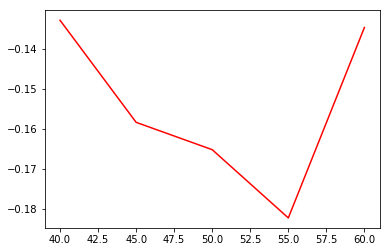

In [743]:
# find the tweets that are in each cluster and print some examples of them
# do pca + dbscan to see if better clusters are obtained
# finding the optimal parameters, forgot to use grid search but I guess this works
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
sil_scores = []
eps_list = np.linspace(0.1,0.2,num=10)
min_sample_list = np.linspace(40,60,num = 5)
for i in tqdm(range(0,5)):
    dbscan = DBSCAN(eps = eps_list, min_samples = 55, metric = 'cosine', n_jobs=-1)
    dbscan.fit(vectorized_tweets_sum_pca)
    sil_scores.append(metrics.silhouette_score(vectorized_tweets_sum_pca, dbscan.labels_, metric='cosine'))
# plt.plot(eps_list, sil_scores, color = 'r');
plt.plot(min_sample_list, sil_scores, color = 'r');

In [744]:
# print(eps_list)
print(min_sample_list)
print(sil_scores)

[40. 45. 50. 55. 60.]
[-0.1328103170123142, -0.1583847657718184, -0.16523173000759597, -0.1823246246369702, -0.13462606715116818]


In [745]:
dbscan = DBSCAN(eps = 0.14, min_samples = 55, metric = 'cosine', n_jobs=-1)
dbscan.fit(vectorized_tweets_sum_pca)

DBSCAN(algorithm='auto', eps=0.14, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=55, n_jobs=-1, p=None)

In [675]:
# just summing instead of averaging over, this is for dbscan as you can specify optimizing by cosine distance
vectorized_tweets_sum = [(i[1].vector) for i in tokens_tweets_i]

In [714]:
# do pca before clustering to for stronger signal and prevent overfitting
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(vectorized_tweets_sum)
vectorized_tweets_sum_pca = pca.fit_transform(vectorized_tweets_sum)
np.sum(pca.explained_variance_ratio_)

0.6019035054124589













  0%|          | 0/10 [00:00<?, ?it/s]











 10%|█         | 1/10 [00:45<06:48, 45.42s/it]











 20%|██        | 2/10 [01:03<04:56, 37.11s/it]











 30%|███       | 3/10 [01:19<03:36, 30.99s/it]











 40%|████      | 4/10 [01:40<02:47, 27.90s/it]











 50%|█████     | 5/10 [01:59<02:05, 25.15s/it]











 60%|██████    | 6/10 [02:19<01:35, 23.80s/it]











 70%|███████   | 7/10 [02:38<01:06, 22.08s/it]











 80%|████████  | 8/10 [02:56<00:42, 21.01s/it]











 90%|█████████ | 9/10 [03:10<00:19, 19.01s/it]











100%|██████████| 10/10 [03:39<00:00, 21.75s/it]













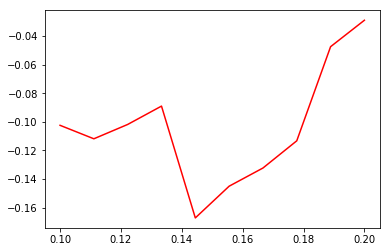

In [772]:
# find the tweets that are in each cluster and print some examples of them
# do pca + dbscan to see if better clusters are obtained
# finding the optimal parameters, forgot to use grid search but I guess this works
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
sil_scores = []
eps_list = np.linspace(0.1,0.2,num=10)
min_sample_list = np.linspace(40,60,num = 5)
for i in tqdm(range(0,10)):
    dbscan = DBSCAN(eps = eps_list[i], min_samples = 55, metric = 'cosine', n_jobs=-1)
    dbscan.fit(vectorized_tweets_sum_pca)
    sil_scores.append(metrics.silhouette_score(vectorized_tweets_sum_pca, dbscan.labels_, metric='cosine'))
# plt.plot(eps_list, sil_scores, color = 'r');
plt.plot(eps_list, sil_scores, color = 'r');

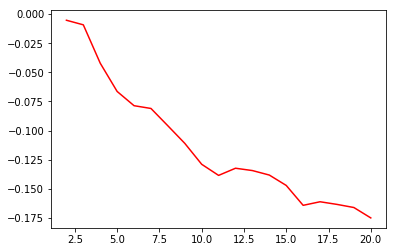

In [774]:
sns.lineplot(list(range(2,21)), sil_scores, color = 'r');

In [744]:
# print(eps_list)
print(min_sample_list)
print(sil_scores)

[40. 45. 50. 55. 60.]
[-0.1328103170123142, -0.1583847657718184, -0.16523173000759597, -0.1823246246369702, -0.13462606715116818]


In [745]:
dbscan = DBSCAN(eps = 0.14, min_samples = 55, metric = 'cosine', n_jobs=-1)
dbscan.fit(vectorized_tweets_sum_pca)

DBSCAN(algorithm='auto', eps=0.14, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=55, n_jobs=-1, p=None)

In [746]:
# dbscan.labels_
rdr2_tweets_w2v_df['db_topic'] = dbscan.labels_

In [747]:
rdr2_tweets_w2v_df.db_topic.unique()

array([-1,  0,  6,  1,  3,  2,  5,  4])

In [759]:
sorted(Counter(dbscan.labels_).items())

[(-1, 6848), (0, 785), (1, 152), (2, 159), (3, 75), (4, 45), (5, 60), (6, 84)]

In [746]:
# dbscan.labels_
rdr2_tweets_w2v_df['db_topic'] = dbscan.labels_

In [771]:
#top tweets of each dbscan-clustered topic, used this to pull out tweets to interpret
db_topic_list = ['N/A','Game of the year discussion','Wanting to play/Trying','GOTY','Spending Time','Horse','Feeling shit/People calling you shit in game']

rdr2_tweets_w2v_df.loc[rdr2_tweets_w2v_df.db_topic == 6][['text','db_topic']].head(20)

,text,db_topic
29,feeling like shit i just wanna play red dead redemption 2 😔🤠,6
191,Lol it is hella slow paced but it definitely doesn’t suck,6
234,Obviously working as intended lol,6
297,I swear about 80% of the NPCs on Red Dead Redemption 2 are nothing but a bag of dicks to you when you just casually say howdy to them. Like wtf did I do bro?! 🤷,6
306,"Steven got the new red dead redemption game and i just heard the girl on the game say “i hate you, you fat sack of shit” 😂😂😂 wtf",6
346,So I’m playing this red dead redemption shit. I ran into the kkk. Wtf at this game. They got hoods on and all. Omg.,6
499,i just beat red dead redemption 2 feel like pure shit,6
517,Red dead redemption is taking forever to download bro wtf,6
545,red dead redemption 2 is one hell of a game,6
648,"red dead redemption 2 sure is a hell of a game, huh",6


In [546]:
# more in depth analysis of k-means clustered topics
centroids = [km.cluster_centers_[i] for i in range(len(km.cluster_centers_))]

In [542]:
# try vader sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
rdr2_tweets_w2v_df['text_vader'] = rdr2_tweets_w2v_df.text.apply(lambda x: re.sub('redemption','',x, flags=re.IGNORECASE))
rdr2_tweets_w2v_df['text_vader'] = rdr2_tweets_w2v_df.text_vader.apply(lambda x: re.sub('dead','',x, flags=re.IGNORECASE))
rdr2_tweets_w2v_df['text_vader'] = rdr2_tweets_w2v_df.text_vader.apply(lambda x: re.sub('red','',x, flags=re.IGNORECASE))
rdr2_tweets_w2v_df['vader_sentiment'] = rdr2_tweets_w2v_df.text_vader.apply(lambda tweet: analyzer.polarity_scores(tweet)['compound']) 
rdr2_tweets_w2v_df.head()

,_id,created_at,favorite_count,retweet_count,screen_name,sentiment,subjectivity,text,text_clean,text_no_stop,topic,text_vader,vader_sentiment
0,5be8c1412af8b82a53bb9ed3,Sun Nov 11 23:54:36 +0000 2018,0,0,Mxster_Shimxda,0.10,0.466667,(Red Dead Redemption is just Grand Theft Yeehaw.,(red dead redemption is just grand theft yeehaw.,grand theft yeehaw,4,( is just Grand Theft Yeehaw.,0.4588
1,5be8c1722af8b82a53bb9edb,Sun Nov 11 23:55:25 +0000 2018,0,0,josepire31,-0.10,0.200000,Red dead redemption 2 para xbox one 👌🏼,red dead redemption 2 para xbox one,2 para xbox one,0,2 para xbox one 👌🏼,0.7297
2,5be8c17d2af8b82a53bb9edd,Sun Nov 11 23:55:36 +0000 2018,0,0,ditzidoggie,-0.10,0.200000,I got the red dead redemption 2 guide so im gonna nerd out and check out these neat locations,i got the red dead redemption 2 guide so im gonna nerd out and check out these neat locations,got 2 guide im gonna nerd check neat locations,7,I got the 2 guide so im gonna nerd out and check out these neat locations,0.1372
4,5be8c1bc2af8b82a53bb9ee4,Sun Nov 11 23:56:39 +0000 2018,0,0,Samantha12Sue,-0.10,0.200000,banana blunts &amp; Red Dead Redemption 2🍌🎮,banana blunts &amp; red dead redemption 2,banana blunts amp 2,7,banana blunts &amp; 2🍌🎮,0.0000
5,5be8c1e02af8b82a53bb9eed,Sun Nov 11 23:57:14 +0000 2018,0,0,BrettVilla,-0.05,0.141667,Joel from The Last of Us is actually Arthur’s father from Red Dead Redemption 2. 🤔,joel from the last of us is actually arthur’s father from red dead redemption 2. 🤔,joel last us actually arthur’s father 2 🤔,5,Joel from The Last of Us is actually Arthur’s father from 2. 🤔,0.0000


In [543]:
rdr2_tweets_w2v_df.groupby(by = 'topic').mean()

,favorite_count,retweet_count,sentiment,subjectivity,vader_sentiment
topic,,,,,
0,0,0,0.033597,0.354020,0.184975
1,0,0,0.007016,0.301163,0.100886
2,0,0,0.003728,0.296655,0.280894
3,0,0,-0.029504,0.324089,-0.103543
4,0,0,-0.032748,0.249208,0.025834
5,0,0,-0.015503,0.290647,0.061481
6,0,0,-0.070637,0.273414,-0.120558
7,0,0,-0.001170,0.328796,0.124235
8,0,0,0.018445,0.324812,0.161519


In [560]:
rdr2_tweets_w2v_df.groupby(by = 'topic').std()

,favorite_count,retweet_count,sentiment,subjectivity,vader_sentiment,dist_from_centroid
topic,,,,,,
0,0.0,0.0,0.226885,0.205528,0.472089,0.586218
1,0.0,0.0,0.246389,0.241390,0.337050,0.825769
2,0.0,0.0,0.162614,0.193552,0.343956,0.526199
3,0.0,0.0,0.209455,0.249961,0.449311,0.885876
4,0.0,0.0,0.174027,0.234767,0.269442,1.046683
5,0.0,0.0,0.220962,0.219733,0.414238,1.142443
6,0.0,0.0,0.199141,0.161942,0.385456,0.884837
7,0.0,0.0,0.226443,0.220140,0.439004,1.276265
8,0.0,0.0,0.274336,0.209314,0.380841,1.531013


In [611]:
cosine_distances(vectorized_tweets[0].reshape(1,-1),km.cluster_centers_[km.labels_[0]].reshape(1,-1))

array([[0.5536924]], dtype=float32)

In [615]:
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_distances

vectorized_tweets_cosdist = [cosine_distances(vectorized_tweets[i].reshape(1,-1),km.cluster_centers_[km.labels_[i]].reshape(1,-1))[0][0] for i in range(0,8208)]
vectorized_tweets_dist = [norm(vectorized_tweets[i]-km.cluster_centers_[km.labels_[i]]) for i in range(0,8208)]
# vectorized_tweets_dist = list(zip(vectorized_tweets, vectorized_tweets_dist))

rdr2_tweets_w2v_df['dist_from_centroid'] = vectorized_tweets_dist
rdr2_tweets_w2v_df['cosine_dist'] = vectorized_tweets_cosdist
rdr2_tweets_w2v_df.head()

,_id,created_at,favorite_count,retweet_count,screen_name,sentiment,subjectivity,text,text_clean,text_no_stop,topic,text_vader,vader_sentiment,dist_from_centroid,cosine_dist
0,5be8c1412af8b82a53bb9ed3,Sun Nov 11 23:54:36 +0000 2018,0,0,Mxster_Shimxda,0.10,0.466667,(Red Dead Redemption is just Grand Theft Yeehaw.,(red dead redemption is just grand theft yeehaw.,grand theft yeehaw,4,( is just Grand Theft Yeehaw.,0.4588,6.000460,0.553692
1,5be8c1722af8b82a53bb9edb,Sun Nov 11 23:55:25 +0000 2018,0,0,josepire31,-0.10,0.200000,Red dead redemption 2 para xbox one 👌🏼,red dead redemption 2 para xbox one,2 para xbox one,0,2 para xbox one 👌🏼,0.7297,0.408095,1.000000
2,5be8c17d2af8b82a53bb9edd,Sun Nov 11 23:55:36 +0000 2018,0,0,ditzidoggie,-0.10,0.200000,I got the red dead redemption 2 guide so im gonna nerd out and check out these neat locations,i got the red dead redemption 2 guide so im gonna nerd out and check out these neat locations,got 2 guide im gonna nerd check neat locations,7,I got the 2 guide so im gonna nerd out and check out these neat locations,0.1372,1.825929,0.416513
4,5be8c1bc2af8b82a53bb9ee4,Sun Nov 11 23:56:39 +0000 2018,0,0,Samantha12Sue,-0.10,0.200000,banana blunts &amp; Red Dead Redemption 2🍌🎮,banana blunts &amp; red dead redemption 2,banana blunts amp 2,7,banana blunts &amp; 2🍌🎮,0.0000,2.218814,0.538913
5,5be8c1e02af8b82a53bb9eed,Sun Nov 11 23:57:14 +0000 2018,0,0,BrettVilla,-0.05,0.141667,Joel from The Last of Us is actually Arthur’s father from Red Dead Redemption 2. 🤔,joel from the last of us is actually arthur’s father from red dead redemption 2. 🤔,joel last us actually arthur’s father 2 🤔,5,Joel from The Last of Us is actually Arthur’s father from 2. 🤔,0.0000,4.364187,0.252314


In [ ]:
rdr2_tweets_w2v_df.loc[rdr2_tweets_w2v_df.topic == 3].sort_values(by = 'cosine_dist', ascending = True).head()

In [625]:
# Find prototypical tweet, most similar to centroid
proto_tweets = []
for i in range(0,10):
    tweet = rdr2_tweets_w2v_df.loc[rdr2_tweets_w2v_df.topic == i].sort_values(by = 'cosine_dist', ascending = True).text.head(5).values
    proto_tweets.append(list(tweet[0:5]))
proto_tweets

[["I finish Red Dead Redemption, Detective Pikachu trailer, Stan Lee's death...lot of things going on today making me feel all kinds of ways",
  "@thegameawards Both GOW and RDR2 need to get the award. fuck spiderman ps4, it was such a predictable piece of shit of a story. Can't say much for the other three because ACO is just another AC game in my eyes and MHW is just dark souls but goofy as hell and why is that other game on here? 🤔",
  'We really gonna pretend any of those other games have a chance against RDR2? How about we save everyone a bit of time and trouble and just mail the trophy to Rockstar and not do this song and dance until next year when someone else has an actual chance.',
  '"The game awards" is a bigger joke than it was last year, which I thought was impossible but Geoff found a way. Apparently the only games that exist are God of Bore, Spider-Man, Red Dead 2, Detroit, Celeste and Assassin\'s Creed Odyssey. They don\'t even try to hide it.',
  "@CrazyNCRCourier @Hae

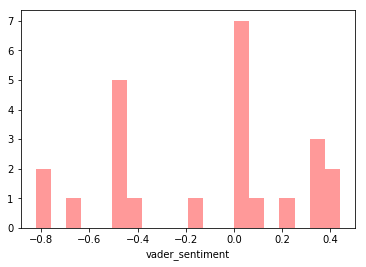

In [673]:
# horse topic
sns.distplot(rdr2_tweets_w2v_df.loc[rdr2_tweets_w2v_df.topic == 6].vader_sentiment,bins=20, kde = False, color = 'r');